In [1]:
from pylab import *
from matplotlib.pyplot import imshow
import numpy as np

%matplotlib inline

from PIL import Image
import pyresample
from pycoast import ContourWriter

from osgeo import gdal, osr
from gdalconst import * 

### Default values and Proj defenition

In [25]:
# res = 30 # 30m <-> 1:100000
# Set possible rounded resolution in meters
resM = 200

# area_extent = [-5000000, -5000000, 5000000, 5000000]
# For some reason the extent is shifted a bit which is very well seen on high res data <305m
# Correcting the extent for both Gray_Earth and GSHHS
from pyproj import Proj, transform
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3413')
x2,y2 = 90, 90-0.01666666666667
x2,y2 = transform(inProj,outProj,x2,y2)
# xmin ymin xmax ymax
area_extent = (-5000000, -5000000 + 4.5*y2, 5000000 - 4.5*x2, 5000000)

# get list of available resolutions
avail_resolution_list = [int(256*math.pow(2, i)) for i in range(15)]

# get first guess size of area
# size = int(256*math.pow(2, 14)/res)
_size = abs(int(area_extent[0] - area_extent[2]) / resM)

# get closest size of area from available resolutions list
size = min(filter(lambda x: _size <= x,
                              avail_resolution_list))

if 1000 < resM <= 100000:
    res = 'i'
elif 350 < resM <= 1000:
    res = 'h'
elif 10 < resM <= 350:
    res = 'f'

area_def = pyresample.geometry.AreaDefinition(
           'epsg_3413_crude', 'NSIDC Polar Stereographic North EPSG:3413',
           'epsg_3413_crude',
           {'proj': 'stere', 'lat_0': '90',
            'lon_0': '-45', 'lat_ts': '70', 'ellps': 'WGS84',
            'datum': 'WGS84', 'units': 'm'}, size, size,
           area_extent
       )

# get the resolution from area_def
resM = int(area_def.pixel_size_x)
# resM = 610
print resM, area_def.pixel_size_x, res, area_def.shape

152 152.500230045 f (65536, 65536)


### Func Defenitions

In [3]:
def tiff2areadef(projection, geotransform, shape):
    # Rewamp projection
    srs = osr.SpatialReference()
    srs.ImportFromWkt(projection)
    proj4 = srs.ExportToProj4()
#     proj4 = srs.ExportToProj4() + '+units=deg'
    proj4_dict = {}
    for i in proj4.replace('+', '').split():
        try:
            key, val = [v.strip() for v in i.split('=')]
        except ValueError:
            continue        
        proj4_dict[key] = val

#     area_extent = [geotransform[0] + geotransform[1]/2,
#                    geotransform[3] + geotransform[5]*shape[0] - geotransform[5]/2,
#                    geotransform[0] + geotransform[1]*shape[1],
#                    geotransform[3]]

#     area_extent = [geotransform[0],
#                    geotransform[3] + geotransform[5]*shape[0],
#                    geotransform[0] + geotransform[1]*shape[1] - geotransform[1]/2,
#                    geotransform[3] + geotransform[5]/2]

#     area_extent = [geotransform[0] + geotransform[1]/2,
#                    geotransform[3] + geotransform[5]*shape[0] - geotransform[5]/2,
#                    geotransform[0] + geotransform[1]*shape[1] - geotransform[1]/2,
#                    geotransform[3] + geotransform[5]/2]

    area_extent = [geotransform[0],
                   geotransform[3] + geotransform[5]*shape[0],
                   geotransform[0] + geotransform[1]*shape[1],
                   geotransform[3]]

#     area_extent = [geotransform[0],
#                    geotransform[3] + geotransform[5]*(shape[0]+.5),
#                    geotransform[0] + geotransform[1]*(shape[1]+.5),
#                    geotransform[3]]

    aid = proj4_dict['proj']
    if aid.lower() == 'utm':
        aid += proj4_dict['zone']
    # give it some kind of ID
    aname = aid + '_' + str(int(sum(geotransform)/1000.))
    
    area_def = pyresample.utils.get_area_def(aname, aname, aid,
                                         proj4_dict,
                                         shape[1], shape[0],
                                         area_extent)

    return area_def


In [4]:
def read_geotiff(filename):
    dst = gdal.Open(filename, GA_ReadOnly)

    #
    # Dataset information
    #
    geotransform = dst.GetGeoTransform()
    projection = dst.GetProjection()
    metadata = dst.GetMetadata()

    #
    # Fetching raster data
    #
    band = dst.GetRasterBand(1)
    shape = (dst.RasterYSize, dst.RasterXSize)

    data = band.ReadAsArray(0, 0, shape[1], shape[0])

    params = dict((('geotransform', geotransform),
                   ('projection', projection),
                   ('metadata', metadata)))

    return params, data

## Natural earth

### gdalwarp geotiff to epsg 3413

In [5]:
# # cd /nfs/store/auxdata/coastline/GRAY_HR_SR_OB_DR/
# # cp GRAY_HR_SR_OB_DR.tif source.tif
# # gdalwarp -t_srs EPSG:3413 -co TILED=NO -te -5000000 -5000000 5000000 5000000 -tr 500 500 -multi -dstnodata "0" source.tif source_crop.tif

# import subprocess
# import os

# # start = 'gdalwarp -overwrite -t_srs EPSG:3413 -co TILED=NO -te -5000000 -5000000 5000000 5000000 -tr 500 500 -multi -dstnodata "0" '

# # opt="+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
# # start = 'gdalwarp -overwrite -t_srs %s -te -5000000 -5000000 5000000 5000000 -ts %s %s -multi -dstnodata "0" ' % (opt, size, size)

# # -te xmin ymin xmax ymax
# # Correcting the extent to avoid shift while warping
# extent = ('-5000000 ' + str(-5000000 + 4.5*y2) + ' ' + str(5000000 - 4.5*x2) + ' 5000000')

# # First generate 305m resolution image - 32768,32768
# start610 = 'gdalwarp -overwrite -r lanczos -of GTiff -s_srs EPSG:4326 -t_srs EPSG:3413 -te %s -ts %s %s -multi -dstnodata "0" ' % (extent, 16384, 16384)
# in_file = '/nfs/store/auxdata/coastline/GRAY_HR_SR_OB_DR/GRAY_HR_SR_OB_DR.tif'
# out_file610 = '/nfs/store/auxdata/coastline/GRAY_HR_SR_OB_DR/source%s.tif' % (610)
# fillnodata = 'gdal_fillnodata.py '

# print start610 + in_file + ' ' + out_file610

# if not os.path.isfile(out_file610):
#     subprocess.call(r'%s %s %s' % (start610, in_file, out_file610),  shell=True )
#     subprocess.call(r'%s %s %s' % (fillnodata, out_file610, out_file610),  shell=True )

### Using gdalwarp to resize image

In [6]:

# cd /nfs/store/auxdata/coastline/GRAY_HR_SR_OB_DR/
# cp GRAY_HR_SR_OB_DR.tif source.tif
# gdalwarp -t_srs EPSG:3413 -co TILED=NO -te -5000000 -5000000 5000000 5000000 -tr 500 500 -multi -dstnodata "0" source.tif source_crop.tif

import subprocess
import os

# start = 'gdalwarp -overwrite -t_srs EPSG:3413 -co TILED=NO -te -5000000 -5000000 5000000 5000000 -tr 500 500 -multi -dstnodata "0" '

# opt="+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
# start = 'gdalwarp -overwrite -t_srs %s -te -5000000 -5000000 5000000 5000000 -ts %s %s -multi -dstnodata "0" ' % (opt, size, size)

# -te xmin ymin xmax ymax
# Correcting the extent to avoid shift while warping
extent = ('-5000000 ' + str(-5000000 + 4.5*y2) + ' ' + str(5000000 - 4.5*x2) + ' 5000000')

# First generate 305m resolution image - 32768,32768
# start305 = 'gdalwarp -overwrite -r lanczos -of GTiff -s_srs EPSG:4326 -t_srs EPSG:3413 -te %s -ts %s %s -multi -dstnodata "97" ' % (extent, 32768, 32768)
start1220 = 'gdalwarp -overwrite -r lanczos -of GTiff -s_srs EPSG:4326 -t_srs EPSG:3413 -te %s -ts %s %s -multi -dstnodata "97" ' % (extent, 8192, 8192)
# Then resize the projected image
start = 'gdalwarp -overwrite -r lanczos -of GTiff -s_srs EPSG:3413 -t_srs EPSG:3413 -ts %s %s -multi' % (size, size)
# start = 'gdalwarp -overwrite -t_srs EPSG:3413 -co TILED=YES -te -5000000 -5000000 5000000 5000000 -multi -dstnodata "0" '

in_file = '/nfs/store/auxdata/coastline/GRAY_HR_SR_OB_DR/GRAY_HR_SR_OB_DR.tif'
# out_file305 = '/nfs/store/auxdata/coastline/GRAY_HR_SR_OB_DR/source%s.tif' % (305)
out_file1220 = '/nfs/store/auxdata/coastline/GRAY_HR_SR_OB_DR/source%s.tif' % (1220)
out_file = '/nfs/store/auxdata/coastline/GRAY_HR_SR_OB_DR/source%s.tif' % (resM)
fillnodata = 'gdal_fillnodata.py '

# if not os.path.isfile(out_file305):
#     print start + in_file + ' ' +out_file
#     subprocess.call(r'%s %s %s' % (start305, in_file, out_file305),  shell=True )
#     subprocess.call(r'%s %s %s' % (fillnodata, out_file305, out_file305),  shell=True )
# if not os.path.isfile(out_file):
#     subprocess.call(r'%s %s %s' % (start, out_file305, out_file),  shell=True )
if not os.path.isfile(out_file1220):
    print start + in_file + ' ' +out_file
    subprocess.call(r'%s %s %s' % (start1220, in_file, out_file1220),  shell=True )
    subprocess.call(r'%s %s %s' % (fillnodata, out_file1220, out_file1220),  shell=True )
if not os.path.isfile(out_file):
    subprocess.call(r'%s %s %s' % (start, out_file1220, out_file),  shell=True )

In [7]:
# GRAY = '/media/SOLabNFS/store/auxdata/coastline/GRAY_HR_SR_OB_DR/GRAY_HR_SR_OB_DR.tif'
GRAY = '/media/SOLabNFS/store/auxdata/coastline/GRAY_HR_SR_OB_DR/source%s.tif' % (resM)

In [8]:
params, data = read_geotiff(GRAY)
msg_area = tiff2areadef(params['projection'],
                        params['geotransform'],
                        data.shape)

### Using python to resize image

In [9]:
# GRAY = '/media/SOLabNFS/store/auxdata/coastline/GRAY_HR_SR_OB_DR/source610.tif'

# data = Image.open(GRAY).convert("L", colors=256)

# data = data.resize((size, size), resample=Image.LANCZOS)

# data = np.array(data)

### Generate tiles

In [10]:
import sys
import os

sys.path.append('/home/mag/Documents/repos/solab/posada/handlers/')

import Tiles.nctiles
reload(Tiles.nctiles)

from Tiles.nctiles import create_nc_tiles, write_attrib_to_nc

In [11]:
# imshow(data[::30,::30], vmin=0, vmax=255)
# gray()
# colorbar()

In [12]:
# def create_nc_tiles(inpath, fn, out_dir, scale=1):
print "Creating NC tiles......."

pn = '/nfs1/store/nctiles/coastlines/'
# pn = '/media/SOLabNFS/hyrax-cluster/data/public/allData/tzh/'

nc_path = os.path.join(pn, 'Gray_Earth_epsg_3413_' + str(resM) + 'm.nc')

if os.path.isfile(nc_path):
    os.remove(nc_path)

startTime = datetime.date.today()

max_zoom_level = create_nc_tiles(data, nc_path, nc_data_type='u1')
write_attrib_to_nc(nc_path, area_extent, startTime,
                   max_zoom_level, area_def.pixel_size_x)

print "%sMb" % str(np.round(os.path.getsize(nc_path)/1024/1024))

del data, params, msg_area, GRAY

Creating NC tiles.......


KeyboardInterrupt: 

In [ ]:
# import numpy as np

# # save it as a compressed .npz file
# np.savez_compressed('data_compressed.npz', data=data)

# # now load it as a numpy.lib.npyio.NpzFile object
# obj = np.load('data_compressed.npz')

# # contains a list of the stored arrays in the format '<name>.npy'
# namelist = obj.zip.namelist()

# # extract 'data.npy' into the current directory
# obj.zip.extract(namelist[0])

# # now we can open the array as a memmap
# data_memmap = np.load(namelist[0], mmap_mode='r+')

# # check that data and data_memmap are identical
# assert np.all(data == data_memmap[:])

## Contour GSHHS and Generate tiles

In [24]:
# cd ~/; [ -d pycoast ] && rm -rf pycoast;
# git clone https://github.com/pytroll/pycoast.git
# cd pycoast
# # change _iterate_db in cw_base
# # replace # for i in range(level): to add lakes support
# # if type(level) == int:
# #     level = range(level-1,level)
# # for i in level:
# sed -i 's/for i in range(level):/if type(level) == int:\n            level = range(level-1,level)\n        for i in level:/' pycoast/cw_base.py
# python setup.py install --record files.txt # cat files.txt | xargs sudo rm -rf

# from PIL import Image
# from pycoast import ContourWriter

# # land = (level == 1);
# # lake = (level == 2);
# # island = (level == 3)

# img = Image.new("L", (1280, 1280))
# cw = ContourWriter('/media/SOLabNFS/store/auxdata/coastline')
# cw.add_coastlines(img, area_def, resolution='l', fill=255, level=1, outline=0)
# cw.add_coastlines(img, area_def, resolution='l', fill=0, level=2, outline=255)
# cw.add_coastlines(img, area_def, resolution='l', fill=255, level=3, outline=0)
# cw.add_rivers(img, area_def, resolution='l', level=range(11), outline=0)
# img.show()

In [26]:
img = Image.new("L", (size, size))

cw = ContourWriter('/media/SOLabNFS/store/auxdata/coastline')
cw.add_coastlines(img, area_def, resolution=res, fill=255, level=1, outline=0)
cw.add_coastlines(img, area_def, resolution=res, fill=0, level=2, outline=255)
cw.add_coastlines(img, area_def, resolution=res, fill=255, level=3, outline=0)
cw.add_rivers(img, area_def, resolution=res, level=range(11), outline=0)

# img.save('coast_test.png')

# img = np.ma.masked_equal(img, 255)
img = np.array(img)

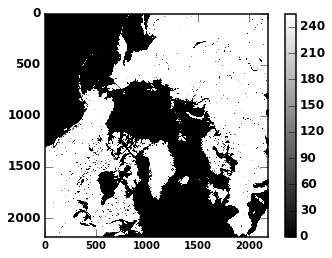

In [27]:
imshow(img[::30,::30], vmin=0, vmax=255)
gray()
colorbar()

In [28]:
import sys
import os

sys.path.append('/home/mag/Documents/repos/solab/posada/handlers/')

import Tiles.nctiles
reload(Tiles.nctiles)

from Tiles.nctiles import create_nc_tiles, write_attrib_to_nc

# def create_nc_tiles(inpath, fn, out_dir, scale=1):
print "Creating NC tiles......."

pn = '/nfs1/store/nctiles/coastlines/'
# pn = '/media/SOLabNFS/hyrax-cluster/data/public/allData/tzh/'

nc_path = os.path.join(pn, 'GSHHS_epsg_3413_' + str(resM) + 'm.nc')

if os.path.isfile(nc_path):
    os.remove(nc_path)

startTime = datetime.date.today()

max_zoom_level = create_nc_tiles(img, nc_path, nc_data_type='u1')
write_attrib_to_nc(nc_path, area_extent, startTime,
                   max_zoom_level, area_def.pixel_size_x)

print "%sMb" % str(np.round(os.path.getsize(nc_path)/1024/1024))

Creating NC tiles.......
80Mb


## Clear REDIS cache

In [30]:
import redis
r = redis.Redis(host='10.170.0.153', password='jM8vBgR4', db=0)
print r.dbsize()
try:
    r.delete(*r.keys('*coast*'))
except:
    pass

1033695


## Cache all

In [32]:
from urllib import urlopen

In [34]:
import os
from netCDF4 import Dataset as ncDataset

# http://10.170.0.153/wms?product=coastline&granule=Gray_Earth_epsg_3413_152m&projection=EPSG%3A3413&vmin=0&vmax=255&zoom=4&x=4&y=8&colormap=gray

pn = '/nfs1/store/nctiles/coastlines/'

# granule_list = listdir(pn)
granule_list = [os.path.join(dn,fn) for dn,_,fns in os.walk(pn) for fn in fns if fn.endswith('152m.nc')]

# product = 'SOLAB-SENTINEL-1'
product = 'coastline'

urls = []
coords = []

x = y = 0

print "Total number of files: %s" %len(granule_list)
# for granule in granule_list:
for granule in {granule_list[0]}:
    if 'Gray_Earth_epsg_3413_152m' in granule:
        colormaps = ['GnBu_r', 'gray', 'bwr']
    else:
        colormaps = ['gray']
    dataset = ncDataset(granule)
    coords = dataset.variables['Data'].shape
    for cmap in colormaps:
        # for zoom in range(coords[0]):
        for zoom in range(7):
            for x in range(2**zoom):
                for y in range(2**zoom):
                    urls.append(
                        'http://ncwms.dev.solab.rshu.ru/wms?' +
                        'product=' + product +
                        '&granule=' + granule[31:-3] +
                        '&projection=EPSG%3A3413' +
                        '&vmin=0&vmax=255&' +
                        'zoom=' + str(zoom) +
                        '&x=' + str(x) +
                        '&y=' + str(y) +
                        '&colormap=' + cmap
                    )
    dataset.close()
urls.sort()

print "Total number of zoom-level requests: %s" %len(urls)

Total number of files: 1
Total number of zoom-level requests: 5461


In [35]:
for u in urls:
    request = urlopen(u)

KeyboardInterrupt: 

## Drafts

In [ ]:
# print -data.shape[0]*0.01666666666667/2+0.01666666666667/2
# print data.shape[0]*0.01666666666667/2-0.01666666666667/2
# print data.shape[1]*0.01666666666667/2-0.01666666666667/2

In [ ]:
# msg_area = pyresample.geometry.AreaDefinition(
#            'epsg_4326', 'epsg_4326',
#            'epsg_4326',
#            {'init': 'epsg:4326'}, data.shape[1], data.shape[0],
#            (-data.shape[1]*0.01666666666667/2+0.01666666666667/2,
#             -data.shape[0]*0.01666666666667/2+0.01666666666667/2,
#              data.shape[1]*0.01666666666667/2-0.01666666666667/2,
#              data.shape[0]*0.01666666666667/2-0.01666666666667/2)
#        )

# msg_area = pyresample.geometry.AreaDefinition(
#            'epsg_4326', 'epsg_4326',
#            'epsg_4326',
#            {'init': 'epsg:4326'}, data.shape[1], data.shape[0],
#            (-179.99166666666667, -89.99166666670266, 179.9916666667387, 89.99166666666667)
#        )

# msg_area = pyresample.geometry.AreaDefinition(
#            'epsg_4326', 'epsg_4326',
#            'epsg_4326',
#            {'init': 'epsg:4326'}, data.shape[1], data.shape[0],
#            (-180, -90, 180, 90)
#        )

# msg_area = pyresample.geometry.AreaDefinition(
#            'epsg_4326', 'epsg_4326',
#            'epsg_4326',
#            {'init': 'epsg:4326'}, data.shape[1], data.shape[0],
#            (-180.0, -90.000000000036, 180.00000000007202, 90.00000000000001)
#        )

# From QGIS
# msg_area = pyresample.geometry.AreaDefinition(
#            'epsg_4326', 'epsg_4326',
#            'epsg_4326',
#            {'init': 'epsg:4326'}, data.shape[1], data.shape[0],
#            (-180.0000000000000000, -90.0000000000359961, 180.0000000000720206, 90.0000000000000142)
#        )


In [ ]:
# print msg_area
# print "\n"
# print area_def

### Reproject

In [ ]:
# data = pyresample.kd_tree.resample_nearest(
#     msg_area, data.ravel(), area_def,
#     radius_of_influence=4*resM,
#     epsilon=0, fill_value=None, nprocs=8
# )
# data = pyresample.kd_tree.resample_gauss(
#     msg_area, data.ravel(), area_def, sigmas=50.,
#     radius_of_influence=4*resM,
#     epsilon=resM, fill_value=None, nprocs=8
# )

In [ ]:
# %%timeit
# # msg_con_quick = pyresample.image.ImageContainerQuick(data, msg_area, nprocs=6)
# # area_con_quick = msg_con_quick.resample(area_def)
# # data = area_con_quick.image_data

# msg_con_nn = pyresample.image.ImageContainerNearest(data, msg_area, nprocs=8, radius_of_influence=4*resM)
# area_con_nn = msg_con_nn.resample(area_def)
# data = area_con_nn.image_data

### Add high res coastline

In [ ]:
# # Correcting the extent for high res data resM<305m
# extent = (-5000000, -5000000 + 4.5*y2, 5000000 - 4.5*x2, 5000000)

# area_def = pyresample.geometry.AreaDefinition(
#            'epsg_3413_crude', 'NSIDC Polar Stereographic North EPSG:3413',
#            'epsg_3413_crude',
#            {'proj': 'stere', 'lat_0': '90',
#             'lon_0': '-45', 'lat_ts': '70', 'ellps': 'WGS84',
#             'datum': 'WGS84', 'units': 'm'}, size, size,
#            extent
#        )

In [ ]:
# necessary_pixels = 3000/resM
# shape = data.shape

# top_array  = np.zeros((necessary_pixels, shape[1]), dtype=data.dtype)
# left_array = np.zeros((necessary_pixels+shape[0], necessary_pixels), dtype=data.dtype)
# data = np.concatenate((top_array, data), axis=0)
# data = np.concatenate((left_array, data), axis=1)

# data = data[0:-necessary_pixels,0:-necessary_pixels]

In [ ]:
# # img = Image.new("L", (size, size))
# # gray_base = Image.open(GRAY)
# # img = Image.fromarray(matplotlib.pylab.plt.cm.ocean(data_res, bytes=True)).convert("P", colors=256)
# img = Image.fromarray(data).convert("L", colors=256)
# del data

# cw = ContourWriter('/media/SOLabNFS/store/auxdata/coastline')
# # cw.add_coastlines(img, area_def, resolution=res, fill=255, level=4, outline=None)
# cw.add_coastlines(img, msg_area, resolution=res, level=4, outline='white')
# cw.add_rivers(img, msg_area, resolution=res, level=11, outline='black')

# img.save('coast_test.png')

# # img = np.ma.masked_equal(img, 255)
# img = np.array(img)

In [ ]:
# # img = Image.new("L", (size, size))
# # gray_base = Image.open(GRAY)
# # img = Image.fromarray(matplotlib.pylab.plt.cm.ocean(data_res, bytes=True)).convert("P", colors=256)
# img = Image.fromarray(data).convert("L", colors=256)
# del data

# cw = ContourWriter('/media/SOLabNFS/store/auxdata/coastline')
# # cw.add_coastlines(img, area_def, resolution=res, fill=255, level=4, outline=None)
# cw.add_coastlines(img, area_def, resolution=res, level=4, outline='white')
# cw.add_rivers(img, area_def, resolution=res, level=11, outline='black')

# # img = np.ma.masked_equal(img, 255)
# img = np.array(img)

In [ ]:
# img = Image.new("L", (size, size))
# cw = ContourWriter('/media/SOLabNFS/store/auxdata/coastline')
# cw.add_coastlines(img, area_def, resolution=res, fill=0, level=4, outline='white')
# cw.add_rivers(img, area_def, resolution=res, level=11, outline='white')

# # img.save('coast_test.png')

# # img = np.ma.masked_equal(img, 255)
# img = np.array(img)

In [ ]:
# imshow(img[::10,::10], vmin=0, vmax=255)
# gray()
# colorbar()

In [ ]:
# imshow(data[6000:8000,12000:22000], vmin=0, vmax=255)
# gray()
# colorbar()

In [ ]:
# imshow(img[6000:8000,12000:22000], vmin=0, vmax=255)
# gray()
# colorbar()

In [ ]:
# import sys
# import os

# sys.path.append('/home/mag/Documents/repos/solab/posada/handlers/')

# import Tiles.nctiles
# reload(Tiles.nctiles)

# from Tiles.nctiles import create_nc_tiles, write_attrib_to_nc, array_size_normalize
# # %%timeit -r 1 -n 1

In [ ]:
# img = array_size_normalize(img)

In [ ]:
# # def create_nc_tiles(inpath, fn, out_dir, scale=1):
# print "Creating NC tiles......."

# pn = '/nfs1/store/nctiles/coastlines/'
# # pn = '/media/SOLabNFS/hyrax-cluster/data/public/allData/tzh/'

# nc_path = os.path.join(pn, 'GSHHS_epsg_3413_' + str(resM) + 'm.nc')
# nc_path_gray = os.path.join(pn, 'GSHHS_GRAY_epsg_3413_' + str(resM) + 'm.nc')

# if os.path.isfile(nc_path):
#     os.remove(nc_path)
# if os.path.isfile(nc_path_gray):
#     os.remove(nc_path_gray)

# startTime = datetime.datetime.strptime('20160421', "%Y%m%d")

# max_zoom_level = create_nc_tiles(img, nc_path, nc_data_type='u1')
# write_attrib_to_nc(nc_path, area_extent, startTime,
#                    max_zoom_level, area_def.pixel_size_x)

# print "%sMb" % str(np.round(os.path.getsize(nc_path)/1024/1024))

In [ ]:
# import redis
# r = redis.Redis(host='10.170.0.153', password='jM8vBgR4', db=0)
# r.dbsize()

In [ ]:
# r.flushall()

### JSON parameter definitions

In [ ]:
# from urllib import urlopen
# import json

In [ ]:
# import json

# gshhsJSON = {}
# # 'u1' (NC_UBYTE)  2**8 =0-255
# # 'u2' (NC_USHORT  2**16=0-65535
# # 'u4' (NC_UINT)   2**32=0-4294967295
# # 'u8' (NC_UINT64) 2**64=0-18446744073709551615
# # if 2\two data types are specified-we generate nc tyle pyramid and export data at max resolution to nc file
# gshhsJSON['nc_data_type'] = ['u1']
# # asarJSON['nc_data_type'] = ['u1']

# with open('/nfs1/store/nctiles/coastlines/coastline.json', 'w') as outfile:
#     json.dump(gshhsJSON, outfile, indent=4, separators=(',', ': '), sort_keys=True)

# outfile.close()